# Project 4: Sentiment Analysis on Twitter Data

**Goal:** Classify tweets as Positive, Neutral, or Negative using machine learning.

## Step 1: Install & Import Libraries

In [1]:
# Install wordcloud if not already available
!pip install wordcloud -q

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import re

import nltk
nltk.download('stopwords', quiet=True)
from nltk.corpus import stopwords

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix

print('All libraries imported!')

All libraries imported!


## Step 2: Upload and Load the Dataset

In [3]:
from google.colab import files
uploaded = files.upload()

Saving Twitter_Data.csv to Twitter_Data.csv


In [4]:
df = pd.read_csv('Twitter_Data.csv')
print('Shape:', df.shape)
df.head()

Shape: (162980, 2)


,clean_text,category
0,when modi promised “minimum government maximum...,-1.0
1,talk all the nonsense and continue all the dra...,0.0
2,what did just say vote for modi welcome bjp t...,1.0
3,asking his supporters prefix chowkidar their n...,1.0
4,answer who among these the most powerful world...,1.0


## Step 3: Clean the Data

In [5]:
# Check for missing values
print(df.isnull().sum())

clean_text    4
category      7
dtype: int64


In [6]:
# Remove rows with missing values
df = df.dropna()
df = df.reset_index(drop=True)

# Convert category from float to int
df['category'] = df['category'].astype(int)

# Give the numbers readable names
df['sentiment'] = df['category'].map({-1: 'Negative', 0: 'Neutral', 1: 'Positive'})

print('Clean dataset shape:', df.shape)
df.head()

Clean dataset shape: (162969, 3)


,clean_text,category,sentiment
0,when modi promised “minimum government maximum...,-1,Negative
1,talk all the nonsense and continue all the dra...,0,Neutral
2,what did just say vote for modi welcome bjp t...,1,Positive
3,asking his supporters prefix chowkidar their n...,1,Positive
4,answer who among these the most powerful world...,1,Positive


## Step 4: Explore the Data

In [7]:
# How many tweets of each type?
print(df['sentiment'].value_counts())

sentiment
Positive    72249
Neutral     55211
Negative    35509
Name: count, dtype: int64


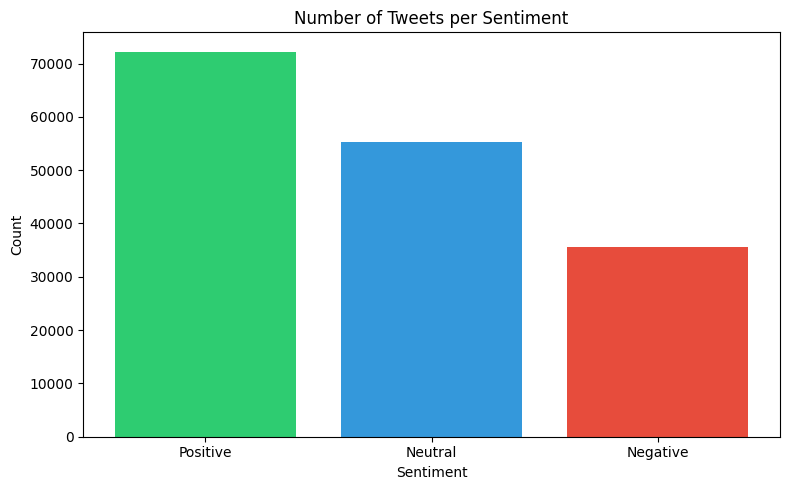

In [8]:
# Bar chart of sentiment counts
counts = df['sentiment'].value_counts()

plt.figure(figsize=(8, 5))
plt.bar(counts.index, counts.values, color=['#2ecc71', '#3498db', '#e74c3c'])
plt.title('Number of Tweets per Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.tight_layout()
plt.savefig('sentiment_counts.png', dpi=150)
plt.show()

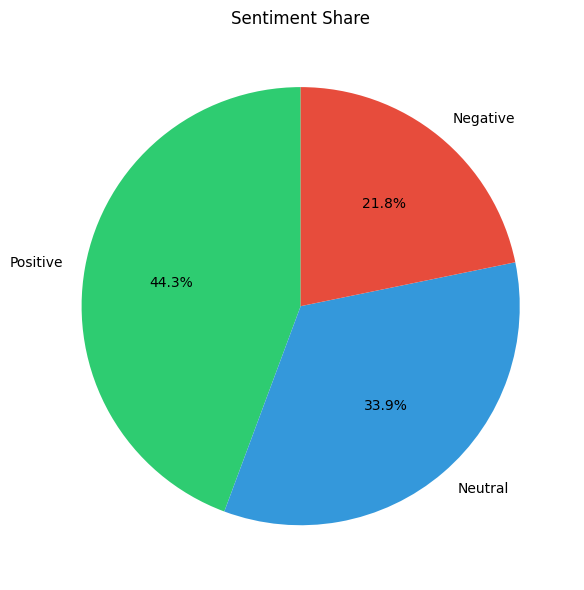

In [9]:
# Pie chart of sentiment share
plt.figure(figsize=(6, 6))
plt.pie(counts.values, labels=counts.index, autopct='%1.1f%%',
        colors=['#2ecc71', '#3498db', '#e74c3c'], startangle=90)
plt.title('Sentiment Share')
plt.tight_layout()
plt.savefig('sentiment_pie.png', dpi=150)
plt.show()

## Step 5: Word Clouds

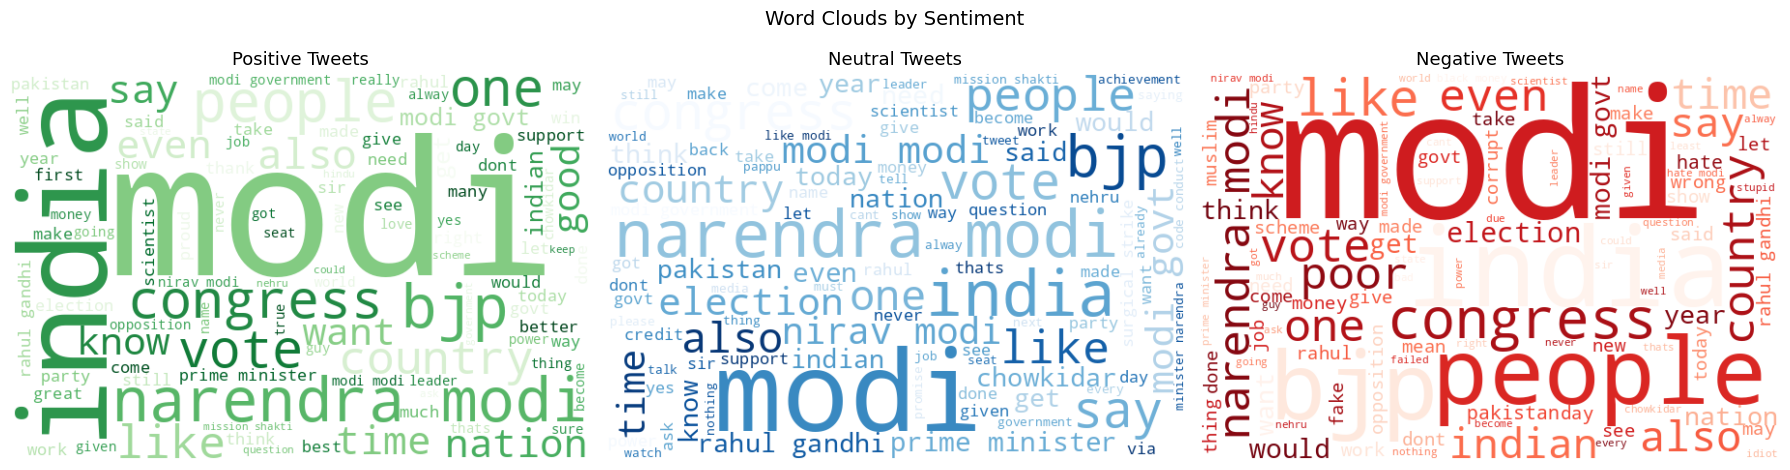

In [10]:
stop_words = set(stopwords.words('english'))

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
sentiments = ['Positive', 'Neutral', 'Negative']
colors_map = ['Greens', 'Blues', 'Reds']

for i, sentiment in enumerate(sentiments):
    # Join all tweets of this sentiment into one big string
    text = ' '.join(df[df['sentiment'] == sentiment]['clean_text'].astype(str).tolist())

    wc = WordCloud(width=600, height=400, background_color='white',
                   colormap=colors_map[i], stopwords=stop_words,
                   max_words=100).generate(text)

    axes[i].imshow(wc, interpolation='bilinear')
    axes[i].axis('off')
    axes[i].set_title(sentiment + ' Tweets', fontsize=13)

plt.suptitle('Word Clouds by Sentiment', fontsize=14)
plt.tight_layout()
plt.savefig('wordclouds.png', dpi=150)
plt.show()

## Step 6: Preprocess Text for Machine Learning

In [11]:
# Simple function to clean each tweet
def clean_tweet(text):
    text = str(text).lower()                    # make lowercase
    text = re.sub(r'http\S+', '', text)         # remove links
    text = re.sub(r'@\w+|#\w+', '', text)       # remove mentions and hashtags
    text = re.sub(r'[^a-z\s]', '', text)        # keep only letters
    words = text.split()
    words = [w for w in words if w not in stop_words]  # remove common words
    return ' '.join(words)

print('Cleaning tweets... this may take 1-2 minutes')
df['clean'] = df['clean_text'].apply(clean_tweet)
print('Done!')
df[['clean_text', 'clean', 'sentiment']].head(3)

Cleaning tweets... this may take 1-2 minutes
Done!


,clean_text,clean,sentiment
0,when modi promised “minimum government maximum...,modi promised minimum government maximum gover...,Negative
1,talk all the nonsense and continue all the dra...,talk nonsense continue drama vote modi,Neutral
2,what did just say vote for modi welcome bjp t...,say vote modi welcome bjp told rahul main camp...,Positive


## Step 7: Convert Text to Numbers (TF-IDF)

In [12]:
X = df['clean']
y = df['category']

# Split into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Convert text to numbers using TF-IDF
tfidf = TfidfVectorizer(max_features=10000)
X_train_vec = tfidf.fit_transform(X_train)
X_test_vec = tfidf.transform(X_test)

print('Training size :', X_train_vec.shape[0])
print('Testing size  :', X_test_vec.shape[0])

Training size : 130375
Testing size  : 32594


## Step 8: Train & Compare Models

In [13]:
# Train 3 simple models and compare
model1 = LogisticRegression(max_iter=1000)
model2 = MultinomialNB()
model3 = LinearSVC(max_iter=2000)

model1.fit(X_train_vec, y_train)
model2.fit(X_train_vec, y_train)
model3.fit(X_train_vec, y_train)

acc1 = accuracy_score(y_test, model1.predict(X_test_vec))
acc2 = accuracy_score(y_test, model2.predict(X_test_vec))
acc3 = accuracy_score(y_test, model3.predict(X_test_vec))

print('Logistic Regression accuracy :', round(acc1 * 100, 2), '%')
print('Naive Bayes accuracy         :', round(acc2 * 100, 2), '%')
print('Linear SVC accuracy          :', round(acc3 * 100, 2), '%')

Logistic Regression accuracy : 89.31 %
Naive Bayes accuracy         : 71.21 %
Linear SVC accuracy          : 91.07 %


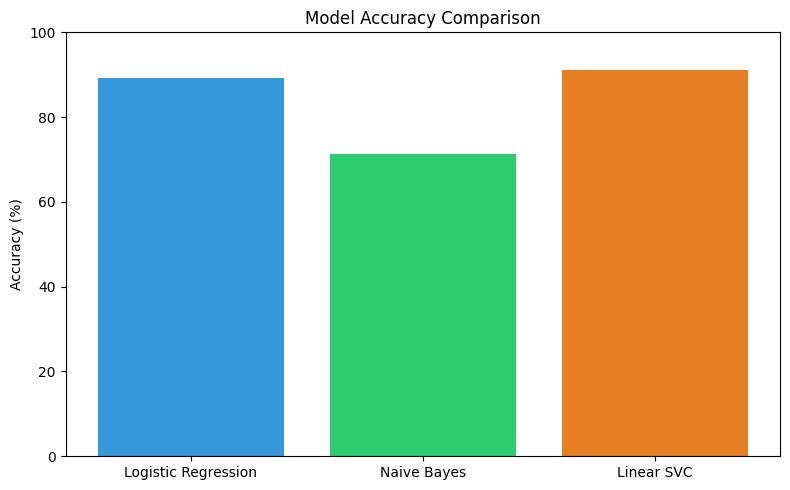

In [14]:
# Bar chart comparing model accuracies
model_names = ['Logistic Regression', 'Naive Bayes', 'Linear SVC']
accuracies = [acc1 * 100, acc2 * 100, acc3 * 100]

plt.figure(figsize=(8, 5))
plt.bar(model_names, accuracies, color=['#3498db', '#2ecc71', '#e67e22'])
plt.title('Model Accuracy Comparison')
plt.ylabel('Accuracy (%)')
plt.ylim(0, 100)
plt.tight_layout()
plt.savefig('model_comparison.png', dpi=150)
plt.show()

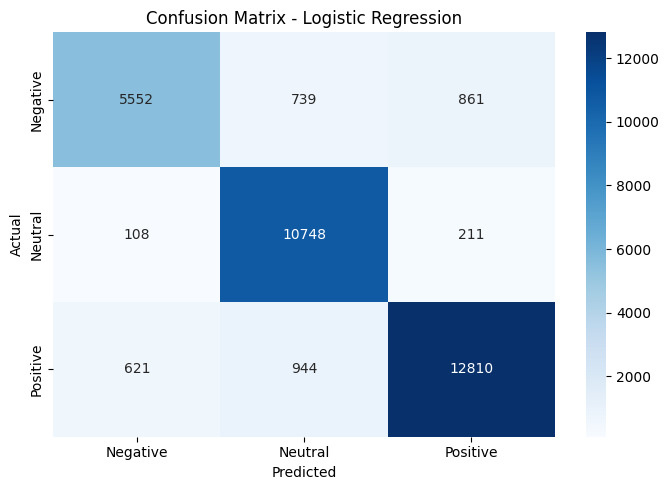

In [15]:
# Confusion matrix for best model (Logistic Regression)
y_pred = model1.predict(X_test_vec)
cm = confusion_matrix(y_test, y_pred)

plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
            xticklabels=['Negative', 'Neutral', 'Positive'],
            yticklabels=['Negative', 'Neutral', 'Positive'])
plt.title('Confusion Matrix - Logistic Regression')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.tight_layout()
plt.savefig('confusion_matrix.png', dpi=150)
plt.show()

In [16]:
# Full classification report
print(classification_report(y_test, y_pred, target_names=['Negative', 'Neutral', 'Positive']))

              precision    recall  f1-score   support

    Negative       0.88      0.78      0.83      7152
     Neutral       0.86      0.97      0.91     11067
    Positive       0.92      0.89      0.91     14375

    accuracy                           0.89     32594
   macro avg       0.89      0.88      0.88     32594
weighted avg       0.89      0.89      0.89     32594



## Step 9: Try It Yourself — Live Prediction

In [17]:
label_names = {-1: 'Negative 😡', 0: 'Neutral 😐', 1: 'Positive 😊'}

def predict_sentiment(tweet):
    cleaned = clean_tweet(tweet)
    vec = tfidf.transform([cleaned])
    result = model1.predict(vec)[0]
    print('Tweet    :', tweet)
    print('Result   :', label_names[result])
    print()

# Test it out
predict_sentiment('I love this product, it is amazing!')
predict_sentiment('This is the worst experience ever.')
predict_sentiment('The meeting is scheduled for tomorrow.')

Tweet    : I love this product, it is amazing!
Result   : Positive 😊

Tweet    : This is the worst experience ever.
Result   : Negative 😡

Tweet    : The meeting is scheduled for tomorrow.
Result   : Neutral 😐



## Step 10: Summary

In [18]:
print('===== SENTIMENT ANALYSIS SUMMARY =====')
print('Total Tweets Analyzed :', len(df))
print('Positive Tweets       :', len(df[df['sentiment'] == 'Positive']))
print('Neutral Tweets        :', len(df[df['sentiment'] == 'Neutral']))
print('Negative Tweets       :', len(df[df['sentiment'] == 'Negative']))
print()
print('Best Model            : Logistic Regression')
print('Best Accuracy         :', round(acc1 * 100, 2), '%')
print()
print('===== KEY FINDINGS =====')
print('1. TF-IDF + Logistic Regression gave the best results.')
print('2. Word clouds clearly show different vocabulary per sentiment.')
print('3. The model can accurately predict tweet sentiment in real time.')

===== SENTIMENT ANALYSIS SUMMARY =====
Total Tweets Analyzed : 162969
Positive Tweets       : 72249
Neutral Tweets        : 55211
Negative Tweets       : 35509

Best Model            : Logistic Regression
Best Accuracy         : 89.31 %

===== KEY FINDINGS =====
1. TF-IDF + Logistic Regression gave the best results.
2. Word clouds clearly show different vocabulary per sentiment.
3. The model can accurately predict tweet sentiment in real time.
